In [1]:
import boilerplate

import pyrtl
from pyrtl import *

import z3

## Verifying a Boolean circuit

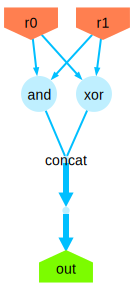

In [2]:
reset_working_block()

r = [Input(bitwidth=1, name="r%d"%i) for i in range(2)]
out = Output(bitwidth=2, name="out")

out <<= concat(r[0] & r[1], r[0] ^ r[1])

working_block()

In [3]:
sim = Simulation()
sim.step({r[0]: 1, r[1]: 0})
sim.inspect(out)

1

In [4]:
from z3 import BitVec, And, Xor, BV2Int

r = [BitVec("r0", 1), BitVec("r1", 1)]
out = BitVec("out", 2)

system = [
    out == z3.Concat(r[0] & r[1], r[0] ^ r[1])
]

spec = BV2Int(r[0]) + BV2Int(r[1]) == BV2Int(out)

s = z3.Solver()
s.add(system)
s.add(z3.Not(spec))
res = s.check()
s.model() if res == z3.sat else res

unsat

In [5]:
wb = working_block()
for net in wb:
    print(net.op, net.op_param or '', [(a.name, a.bitwidth) for a in net.args], [(a.name, a.bitwidth) for a in net.dests])

^  [('r0', 1), ('r1', 1)] [('tmp1', 1)]
&  [('r0', 1), ('r1', 1)] [('tmp0', 1)]
c  [('tmp0', 1), ('tmp1', 1)] [('tmp2', 2)]
w  [('tmp2', 2)] [('out', 2)]


_Exercise_. We would like to generate `spec` automatically from the net elements in the hardware design.
Write a loop that constructs such a formula.

In [6]:
# go for it


In [7]:
reset_working_block()

_r = [Input(bitwidth=2, name="r%d"%i) for i in range(2)]
out = Output(bitwidth=3, name="out")

r = [[_r[0][0], _r[0][1]], [_r[1][0], _r[1][1]]]

c = [r[0][0] & r[1][0]]
c.append(c[0] & (r[0][1] | r[1][1]) | r[0][1] & r[1][1])

out <<= concat(c[1], r[0][1] ^ r[1][1] ^ c[0], r[0][0] ^ r[1][0])

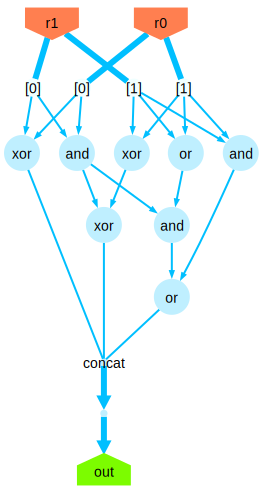

In [8]:
working_block()

In [9]:
wb = working_block()
for net in wb:
    print(net.op, net.op_param or '', [(a.name, a.bitwidth) for a in net.args], [(a.name, a.bitwidth) for a in net.dests])


s (1,) [('r0', 2)] [('tmp4', 1)]
s (0,) [('r0', 2)] [('tmp3', 1)]
s (0,) [('r1', 2)] [('tmp5', 1)]
s (1,) [('r1', 2)] [('tmp6', 1)]
|  [('tmp4', 1), ('tmp6', 1)] [('tmp8', 1)]
&  [('tmp4', 1), ('tmp6', 1)] [('tmp10', 1)]
^  [('tmp4', 1), ('tmp6', 1)] [('tmp12', 1)]
&  [('tmp3', 1), ('tmp5', 1)] [('tmp7', 1)]
^  [('tmp3', 1), ('tmp5', 1)] [('tmp14', 1)]
^  [('tmp12', 1), ('tmp7', 1)] [('tmp13', 1)]
&  [('tmp7', 1), ('tmp8', 1)] [('tmp9', 1)]
|  [('tmp9', 1), ('tmp10', 1)] [('tmp11', 1)]
c  [('tmp11', 1), ('tmp13', 1), ('tmp14', 1)] [('tmp15', 3)]
w  [('tmp15', 3)] [('out', 3)]


#### Verifying
_Following is a manual translation of the circuit into a Boolean formula._

In [10]:
from z3 import BitVec, BV2Int

_r = [BitVec('r%i'%i, 2) for i in range(2)]
out = BitVec('out', 3)

r = [[z3.Extract(i, i, b) for i in range(2)] for b in _r]

c = [r[0][0] & r[1][0]]
c.append(c[0] & (r[0][1] | r[1][1]) | r[0][1] & r[1][1])

s = z3.Solver()
s.add(out == z3.Concat(c[1], r[0][1] ^ r[1][1] ^ c[0], r[0][0] ^ r[1][0]))

In [11]:
s

[out ==
 Concat(Concat(Extract(0, 0, r0) &
               Extract(0, 0, r1) &
               (Extract(1, 1, r0) | Extract(1, 1, r1)) |
               Extract(1, 1, r0) & Extract(1, 1, r1),
               Extract(1, 1, r0) ^
               Extract(1, 1, r1) ^
               Extract(0, 0, r0) & Extract(0, 0, r1)),
        Extract(0, 0, r0) ^ Extract(0, 0, r1))]

In [12]:
from z3 import BitVec, BV2Int

_r = [BitVec('r%i'%i, 2) for i in range(2)]
out = BitVec('out', 3)

r = [[z3.Extract(i, i, b) for i in range(2)] for b in _r]

c = [r[0][0] & r[1][0]]
c.append(c[0] & (r[0][1] | r[1][1]) | r[0][1] & r[1][1])

s = z3.Solver()
s.add(out == z3.Concat(c[1], r[0][1] ^ r[1][1] ^ c[0], r[0][0] ^ r[1][0]))

In [13]:
#s.add(_r[0] != 0)
s.check()
s.model()

[r0 = 0, r1 = 0, out = 0]

In [14]:
res = s.check([z3.Not(BV2Int(_r[0]) + BV2Int(_r[1]) == BV2Int(out))])
res

unsat

_Implement a function_ `net_to_smt` _that will do the same (or equivalent) translation automatically._

In [15]:
from circuit import net_to_smt

wires, ops, assertions = net_to_smt(wb)

s = z3.Solver()
for phi in assertions:
    print(phi)
    s.add(phi)

ImportError: cannot import name 'net_to_smt' from 'circuit' (/Users/yazanmulla/Desktop/techcs-236346FORK/z3env/lib/python3.13/site-packages/circuit/__init__.py)

In [38]:
res = s.check([z3.Not(BV2Int(wires.lookup('r0')) + BV2Int(wires.lookup('r1')) ==
               BV2Int(wires.lookup('out')))])
res

sat

In [39]:
s.model() if res == z3.sat else None

[tmp38 = 1,
 tmp37 = 0,
 tmp46 = 0,
 tmp39 = 0,
 tmp45 = 1,
 tmp41 = 0,
 tmp44 = 1,
 tmp36 = 1,
 r0 = 2,
 tmp40 = 1,
 r1 = 2,
 tmp43 = 1,
 tmp42 = 1,
 out = 6,
 tmp47 = 6,
 tmp35 = 0]

## Verify something with memory?

In [40]:
reset_working_block()

sp = Register(bitwidth=3, name='sp')
mem = MemBlock(bitwidth=3, addrwidth=3, name='mem', max_write_ports=2)

mem[sp] <<= (mem[sp] + 1)[:3]
mem[0] <<= 0
sp.next <<= sp + 1

In [43]:
sim_trace = pyrtl.SimulationTrace()
sim = pyrtl.Simulation(tracer=sim_trace)
for cycle in range(13):
    sim.step({})

sim_trace.render_trace()

<IPython.core.display.Javascript object>

In [44]:
sim.inspect_mem(mem)

{0: 0, 1: 2, 2: 2, 3: 2, 4: 2, 5: 1, 6: 1, 7: 1}

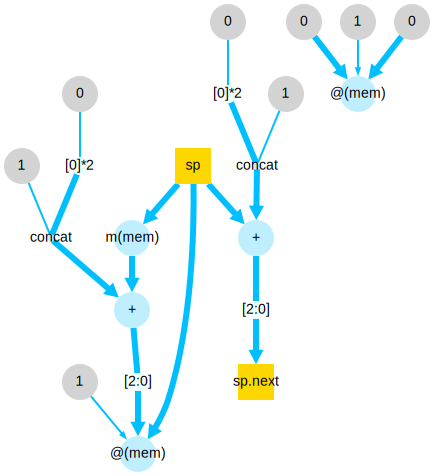

In [45]:
working_block()

In [ ]:
wb = working_block()
for net in wb:
    print(net.op, net.op_param or '', [(a.name, a.bitwidth) for a in net.args], [(a.name, a.bitwidth) for a in net.dests])

In [ ]:
list(wb)

In [ ]:
# an example for a Z3 function for handling arrays
z3.K??

In [ ]:
vsp = z3.BitVec('sp', 3)
vmem = z3.Array('mem', z3.BitVecSort(3), z3.BitVecSort(3))

state_vars = [vsp, vmem]
Inv = z3.Function("Inv", *(v.sort() for v in state_vars), z3.BoolSort())

rules = [
    Inv(0, z3.K(z3.BitVecSort(3), z3.BitVecVal(0, 3))),
    z3.Implies(Inv(vsp, vmem), Inv(vsp + 1, z3.Store(vmem, vsp, vmem[vsp] + 1))),
    z3.Implies(Inv(vsp, vmem), z3.Or(vmem[1] == vmem[2], vmem[1] == vmem[2] + 1))
]

In [ ]:
from verification_utils import CHCs
chcs = CHCs(rules)
s = chcs.create_solver()

In [ ]:
s.check()

In [ ]:
s.model()

_You will most likely need to extend your previous implementation of_ `net_to_smt` _to handle state update._

In [ ]:
wires, ops, assertions = net_to_smt(working_block(), mems=[mem])

tr = []
for phi in assertions:
    print(phi)
    tr.append(phi)

In [ ]:
state_vars = [wires.lookup(v) for v in ['sp', 'mem']]
Inv = z3.Function("Inv", *(v.sort() for v in state_vars), z3.BoolSort())

_Now implement_ `create_rules` _so that it generates appropriate Horn clauses automatically._

_E.g. verify that_ `mem[1]` _and_ `mem[2]` _are at most 1 apart:_ `mem[1] == mem[2] ∨ mem[1] == mem[2] + 1`

In [ ]:
def create_rules():
    sp, mem = state_vars
    
    pre = z3.And(sp == 0, mem == z3.K(z3.BitVecSort(3), z3.BitVecVal(0, 3)))
    post = z3.Or(mem[1] == mem[2], mem[1] == mem[2] + 1)
    
    start = z3.Implies(pre, Inv(*state_vars))
    step = z3.Implies(z3.And(Inv(*state_vars), *tr), Inv(*(ops.primed_vars[v] for v in state_vars)))
    end = z3.Implies(z3.And(Inv(*state_vars), z3.Not(post)), False)
    
    return [start, step, end]

rules = create_rules()

In [ ]:
chcs = CHCs(rules)
s = chcs.create_solver()

In [ ]:
s.check()

In [ ]:
s.model()